In [1]:
import numpy as np
import pandas as pd
import os
import h5py
import wandb

import string
import random

import torch 
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint


from torch import optim, utils, Tensor

import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import sklearn.linear_model


In [2]:


import os
os.environ['HTTP_PROXY']="http://www-int.dkfz-heidelberg.de:80"
os.environ['HTTPS_PROXY']="http://www-int.dkfz-heidelberg.de:80"


In [3]:

slide_meta = pd.read_csv("../metadata/labels_with_new_batch.csv")
ct_scoring = pd.read_csv("../metadata/CT_3_Class_Draft.csv")

ct_scoring["txt_idat"] = ct_scoring["idat"].astype("str")
ct_scoring.index = ct_scoring.txt_idat
slide_meta.index = slide_meta.idat
ct_scoring = ct_scoring.drop("txt_idat", axis=1)
slide_meta = slide_meta.drop("idat", axis=1)
slide_annots = slide_meta.join(ct_scoring, lsuffix="l")


slide_annots['file'] = slide_annots.uuid + ".h5"

slide_annots.index = slide_annots.uuid

In [4]:
slide_annots['labels'] = np.abs(1-slide_annots.CT_class.factorize(sort=True)[0])

In [5]:

api = wandb.Api()


In [6]:
runs = api.runs(path="psmirnov/UKHD_RetCLL_299_CT", filters={"group": "EG8JRX"})

In [7]:
train_preds = list()
train_labels = list()
train_probs = list()

valid_preds = list()
valid_labels = list()
valid_probs = list()

test_preds = list()
test_labels = list()
test_probs = list()

train_mean = list()
valid_mean = list()
test_mean = list()
    
train_combined = list()
valid_combined = list()
test_combined = list()


In [8]:
for ii in range(len(runs)):
    arts = runs[ii].logged_artifacts()
    arts_dict = {a.name.removesuffix(':'+a.version): a for a in arts}
    training_slides = arts_dict['fold'].get('training').get_dataframe()
    valid_slides = arts_dict['fold'].get('validation').get_dataframe()
    testing_slides = arts_dict['fold'].get('testing').get_dataframe()
    
    train_data = slide_annots.loc[training_slides[0]]
    valid_data = slide_annots.loc[valid_slides[0]]
    test_data = slide_annots.loc[testing_slides[0]]
    
    train_mean.append(pd.merge(train_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    valid_mean.append(pd.merge(valid_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    test_mean.append(pd.merge(test_data,train_data.groupby('family').labels.mean(), how='left', left_on='family',right_on='family').labels_y)
    
    train_labels.append(np.abs(1-train_data.CT_class.factorize(sort=True)[0]))
    train_preds.append(arts_dict['preds'].get('training').get_dataframe())
    train_probs.append(arts_dict['preds'].get('training_probs').get_dataframe())

    valid_labels.append(np.abs(1-valid_data.CT_class.factorize(sort=True)[0]))
    valid_preds.append(arts_dict['preds'].get('validation').get_dataframe())
    valid_probs.append(arts_dict['preds'].get('validation_probs').get_dataframe())
    
    test_labels.append(np.abs(1-test_data.CT_class.factorize(sort=True)[0]))
    test_preds.append(arts_dict['preds'].get('testing').get_dataframe())
    test_probs.append(arts_dict['preds'].get('testing_probs').get_dataframe())
    
    logistic_model= sklearn.linear_model.LogisticRegression(penalty=None)

    X_train = np.stack([np.transpose(train_probs[ii][0]), np.array(train_mean[ii]).transpose()])
    X_valid = np.stack([np.transpose(valid_probs[ii][0]), np.array(valid_mean[ii]).transpose()])
    X_test = np.stack([np.transpose(test_probs[ii][0]), np.array(test_mean[ii]).transpose()])
     
    
    logistic_model.fit(X_train.transpose()[~np.isnan(train_mean[ii])], train_labels[ii][~np.isnan(train_mean[ii])])
    train_combined.append(logistic_model.predict_proba(X_train.transpose()[~np.isnan(train_mean[ii])]))
    valid_combined.append(logistic_model.predict_proba(X_valid.transpose()[~np.isnan(valid_mean[ii])]))
    test_combined.append(logistic_model.predict_proba(X_test.transpose()[~np.isnan(test_mean[ii])]))


wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   3 of 3 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   6 of 6 files downloaded.  
wandb:   3 of 3 files downlo

In [9]:
train_mean = np.concatenate(train_mean)
valid_mean = np.concatenate(valid_mean)
test_mean = np.concatenate(test_mean)


In [10]:
train_combined = np.concatenate(train_combined)
valid_combined = np.concatenate(valid_combined)
test_combined = np.concatenate(test_combined)

In [11]:
len(np.concatenate(valid_preds))

1900

In [12]:
len(np.concatenate(test_preds))

1907

In [13]:
train_labels = np.concatenate(train_labels)
train_preds = np.concatenate(train_preds)
train_probs = np.concatenate(train_probs)


In [14]:
train_combined

array([[8.42592307e-01, 1.57407693e-01],
       [1.45476523e-01, 8.54523477e-01],
       [2.59050760e-02, 9.74094924e-01],
       ...,
       [9.99999444e-01, 5.55611110e-07],
       [9.99999817e-01, 1.83186730e-07],
       [9.92754674e-01, 7.24532595e-03]])

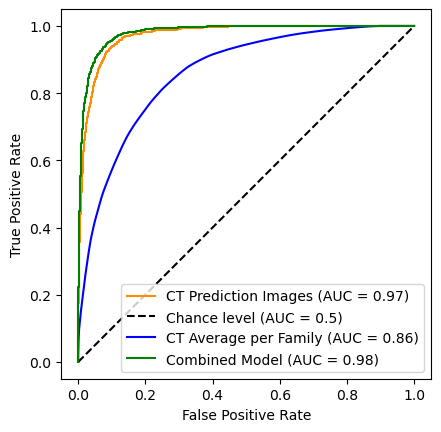

In [15]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

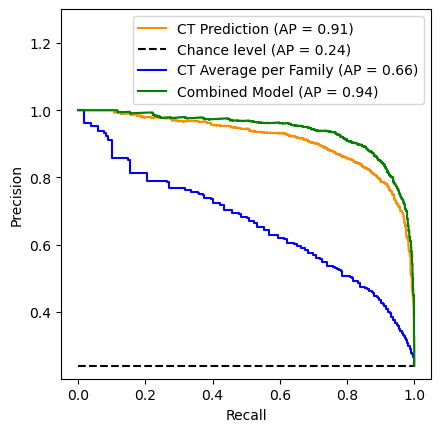

In [16]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    train_labels,
    train_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    train_mean[~np.isnan(train_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    train_labels[~np.isnan(train_mean)],
    # np.ones(preds_logistic.shape[0]),
    train_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

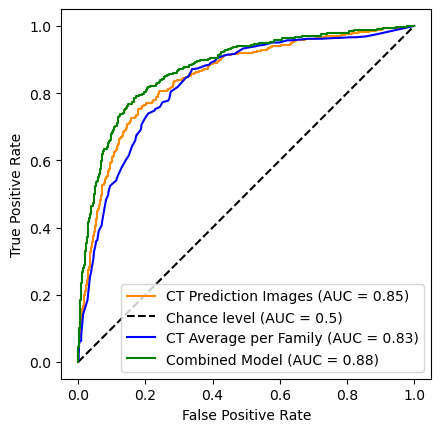

In [255]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

In [18]:
valid_labels = np.concatenate(valid_labels)
valid_preds = np.concatenate(valid_preds)
valid_probs = np.concatenate(valid_probs)

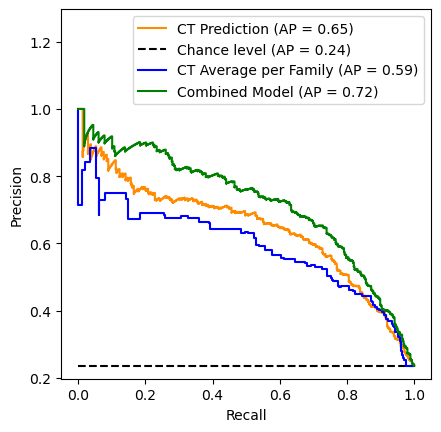

In [19]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    valid_labels,
    valid_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    valid_mean[~np.isnan(valid_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    valid_labels[~np.isnan(valid_mean)],
    # np.ones(preds_logistic.shape[0]),
    valid_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()

In [20]:
test_labels = np.concatenate(test_labels)
test_preds = np.concatenate(test_preds)
test_probs = np.concatenate(test_probs)


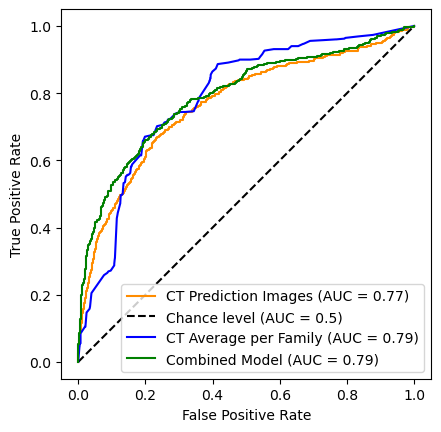

In [21]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(
    test_labels,
    test_probs,
    name="CT Prediction Images",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
RocCurveDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    test_mean[~np.isnan(test_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax,
)
RocCurveDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    # np.ones(preds_logistic.shape[0]),
    test_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("")
plt.legend()
plt.show()

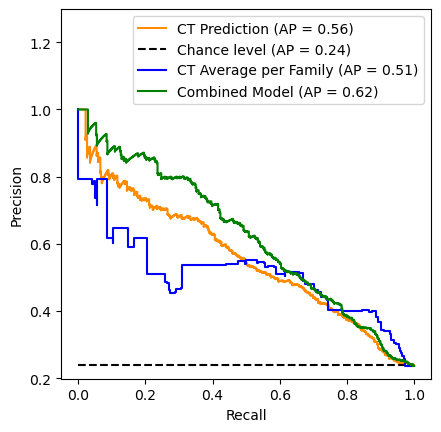

In [22]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(
    test_labels,
    test_probs,
    name="CT Prediction",
    color="darkorange",
    plot_chance_level=True,
    ax=ax
)
PrecisionRecallDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    test_mean[~np.isnan(test_mean)],
    name="CT Average per Family",
    color="blue",
    ax=ax
)

PrecisionRecallDisplay.from_predictions(
    test_labels[~np.isnan(test_mean)],
    # np.ones(preds_logistic.shape[0]),
    test_combined[:,1],
    # np.maximum( np.array(valid_data.labels).transpose(),np.transpose(valid_probs)),
    name="Combined Model",
    color="green",
    ax=ax
)

plt.axis("square")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("")
plt.legend()
plt.show()